In [501]:
import numpy as np
import pyedflib

import pandas as pd
from gtda.time_series import SingleTakensEmbedding
from gtda.homology import VietorisRipsPersistence
from gtda.diagrams import PersistenceEntropy, Amplitude, NumberOfPoints, ComplexPolynomial, PersistenceLandscape, HeatKernel, Silhouette, BettiCurve, PairwiseDistance, ForgetDimension
from sklearn.model_selection import train_test_split
import random

# Choose EEG or EMG

In [502]:
# Choose if you want to look at EEG or EMG data

data_type = "EEG" # Does not have an effect yet, will be added later when processing anesthesia data
#data_type = "EMG"

# Import Data

In [503]:
# EEG/EMG data

def read_edf_file(file_path):
    """
    Reads an .edf file and returns the EEG and EMG streams as pandas DataFrames.
    """
    f = pyedflib.EdfReader(file_path)

    # Assuming the EEG channel is the first channel and EMG is the second channel
    eeg_signal = f.readSignal(0)
    emg_signal = f.readSignal(1)

    # Extract the channel names for the DataFrame
    eeg_channel_name = f.getSignalLabels()[0]
    emg_channel_name = f.getSignalLabels()[1]

    # Get the sample frequency
    sample_frequency = f.getSampleFrequency(0)  # Assuming both streams have the same frequency

    # Calculate the timestamps for the samples
    n_samples = min(len(eeg_signal), len(emg_signal))
    time = [i / sample_frequency for i in range(n_samples)]

    # Create pandas DataFrame
    df = pd.DataFrame({
        'Time': time,
        eeg_channel_name: eeg_signal[:n_samples],
        emg_channel_name: emg_signal[:n_samples],
    })

    # Close the EdfReader
    f.close()

    return df


# Read file
file = 'Data/edf_293.edf'

# Convert to pandas DataFrame
data = read_edf_file(file)
data = data.iloc[2000:] # The first label is NaN... Therefore we have to remove the first 2000 values corresponding to the first label
data.to_csv("Data/TS_Data.csv") # Save for Data Exploration

In [504]:
# Labels

# Read data
label_df = pd.read_csv("Data/Data_293.csv")
labels = label_df["NAPS_Numeric"].iloc[1:] # The first label is NaN

# Convert to list
labels = [int(label) for label in labels]


# Preprocessing

## Segmenting Data

In [505]:
def segment_data(df, segment_size, step_size = 2):
    """
    Segments time-series data into EEG and EMG segments.

    Parameters:
    - df (DataFrame): The input dataframe containing the columns "Time", "EEG" and "EMG".
    - segment_size (float): The desired size of each segment in seconds.
    - step_size (float, optional): The step size of "Time" in milliseconds. Default is 2 millisecond.

    Returns:
    Tuple of two lists:
    - List of EEG segments.
    - List of EMG segments.
    """

    n_segments = int(df["Time"].iloc[-1]) // segment_size
    eeg_segments = []
    emg_segments = []

    for i in range(n_segments):
        start_idx = int(i* segment_size*1000/step_size)
        end_idx = start_idx + int(segment_size*1000/step_size)
        segment = df.iloc[start_idx:end_idx]
        eeg_segments.append(list(segment["EEG"]))
        emg_segments.append(list(segment["EMG"]))

    return eeg_segments, emg_segments

In [506]:
# Segment the data
segment_size = 4  # seconds
eeg_segments, emg_segments = segment_data(data, segment_size, step_size = 2)

## Choose Train and Test Data Indices

In [507]:
# Choose test data set size for classification later (recommended: 0.2-0.3)

test_size = 0.3

In [555]:
# Split the labels into training and testing set labels
all_indices = np.arange(len(labels))
0
_, _, _, _, train_indices, test_indices = train_test_split(eeg_segments, labels, all_indices, test_size=test_size, random_state=32)

In [580]:
# How many segments per label do you want to analyze?

no_segments = len(labels) # complete data in this case

In [581]:
# Create dictionaries which contain all (test and train) segment indices (values) for each label (key)
label_list = [1, 3, 5, 7]


train_indices_dict = {}
test_indices_dict = {}
all_indices_dict = {}


for label in label_list: 
    indices = [index for index, value in enumerate(labels) if (value == label and index in train_indices)][:no_segments]
    train_indices_dict[label] = indices

for label in label_list: 
    indices = [index for index, value in enumerate(labels) if (value == label and index in test_indices)][:no_segments]
    test_indices_dict[label] = indices

for label in label_list:
    indices = [index for index, value in enumerate(labels) if (value == label)][:no_segments]
    all_indices_dict[label] = indices

## Find outliers in segments of label 1, 3 and 5 and label them as 7

In [582]:
# Save the segments of each label for finding outliers

label_segments = {} # Addionally 
time_series_per_label = {}

for label in label_list:
    ts_segments = []
    time_series = []
    for idx in all_indices_dict[label]:   
        # Later use for finding outliers
        ts_segments.append(eeg_segments[idx]) # segment
        time_series.extend(eeg_segments[idx]) # flat TS

    label_segments[label] = ts_segments
    time_series_per_label[label] = time_series

In [583]:
def detect_artifacts(segments_of_our_label, all_segments, indices_of_our_label, threshold):
    
    # Calculate the mean and standard deviation of the maximum absolute value in each segment
    # of all time series

    all_mav = []  # maximal absolute values of all segments
    
    for segment in all_segments:
        all_mav.append(np.max(np.abs(segment)))

    mean = np.mean(all_mav)
    std = np.std(all_mav)

    mav_of_our_label = [] # maximal absolute values of all segments of our labels
    
    for segment in segments_of_our_label:
        mav_of_our_label.append(np.max(np.abs(segment)))
    
    # Calculate the Z-scores for each data point
    z_scores = (mav_of_our_label - mean) / std
          
    # Find data points with Z-scores above the threshold (outliers)
    outliers_indices = np.where(np.abs(z_scores) > threshold)[0]

    outliers_indices_in_complete_data = [indices_of_our_label[idx] for idx in outliers_indices]

    return outliers_indices, outliers_indices_in_complete_data 

In [584]:
outlier_indices = {}
outliers_indices_in_complete_data = {}



for label in label_list:
    outlier_indices[label], outliers_indices_in_complete_data[label] = detect_artifacts(label_segments[label], eeg_segments, all_indices_dict[label], threshold=3)

### Do a check

In [585]:
# Label to check
label_to_check = 1

outlier_indices[label_to_check]

array([126, 171])

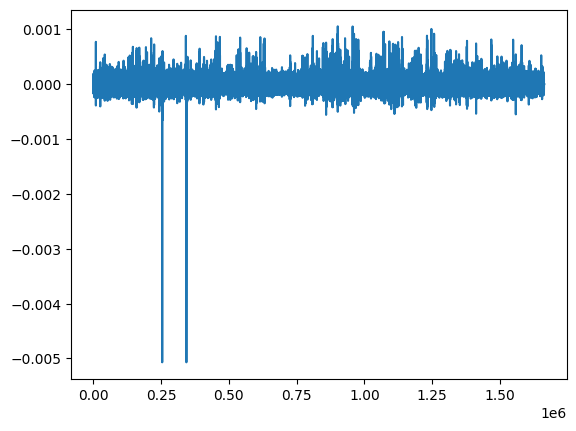

In [586]:
import matplotlib.pyplot as plt

plt.plot(time_series_per_label[label_to_check])

For label 1: Apparently it is correct that label 1 has 2 outliers.

For label 3 & 5: They do not seem to have outliers, which is what we computed.

For label 7: Apparently it is correct that label 1 has 1 outliers.

In [587]:
all_mav = []  # maximal absolute values of all segments

for segment in label_segments[label_to_check]:
    all_mav.append(np.max(np.abs(segment)))

num_outliers = len(outlier_indices[label_to_check])
idx = np.argpartition(all_mav, -num_outliers)
print(idx[-num_outliers:])

[126 171]


For both label 1 and 7, the indices of the outliers found by both methods are exactly the same.

### Relabel outliers as 7

In [591]:
for label in [1, 3, 5]:
    for idx in outliers_indices_in_complete_data[label]:
        if idx in train_indices_dict[label]:
            train_indices_dict[label].remove(idx)
            train_indices_dict[7].append(idx)
            
        if idx in test_indices_dict[label]: 
            test_indices_dict[label].remove(idx)
            test_indices_dict[7].append(idx)

        if idx in all_indices_dict[label]: 
            all_indices_dict[label].remove(idx)
            all_indices_dict[7].append(idx)

181


In [592]:
# Save segments of single labels for data exploration

for label in label_list:
    time_series = []
    for idx in all_indices_dict[label]:
        # Save for data explorationf
        time_series.extend(eeg_segments[idx])
        np.save('Data/Segments_for_Label_'+str(label)+'.npy', np.array(time_series, dtype=object), allow_pickle=True)

# Persistence Diagrams

## Finding the optimal embedding dimension and time delay

There are two techniques that can be used to determine these parameters automatically:
- Mutual information to determine the time delay
- False nearest neighbours to determine the embedding dimension

In [384]:
# Initialise the embedding
max_embedding_dimension = 30
max_time_delay = 30
stride = 5

embedder = SingleTakensEmbedding(
    parameters_type="search",
    time_delay=max_time_delay,
    dimension=max_embedding_dimension,
    stride=stride,
)

In [385]:
def find_optimal_parameters(embedder, segments, max_index, iterations = 8):
    """
    Finds (approximate) optimal embedding parameters by averaging optimal parameters of random segments.

    Parameters:
    - embedder (object): defined by SingleTakensEmbedding() or similar
    - segments (list of lists): Complete EEG/EMG segments
    - max_index (int): How many segments there are
    - iteratiors (int): How many random indices to sample

    Returns:
    Tuple of two floats:
    - Average optimal embedding dimension
    - Average optimal time delay
    """


    optimal_embeddings_dimensions = []
    optimal_time_delays = []
    
    for _ in range(iterations):
        random_index = random.randint(0, max_index)
        embedding = embedder.fit_transform(segments[random_index])
        
         # append optimal embedding dimension for this segment
        optimal_embeddings_dimensions.append(embedder.dimension_)

        # append optimal time delay for this segment
        optimal_time_delays.append(embedder.time_delay_)

        print("The optimal embedding dimension is " + str(np.mean(optimal_embeddings_dimensions)) + 
              " and the optimal time delay is " + str(np.mean(optimal_time_delays)))
        
        return int(np.mean(optimal_embeddings_dimensions)), int(np.mean(optimal_time_delays))

In [386]:
# Compute optimal embedding parameters
embedding_dimension, embedding_time_delay = find_optimal_parameters(embedder, eeg_segments, len(labels), iterations = 8)

The optimal embedding dimension is 7.0 and the optimal time delay is 28.0


## Creating Persistence Diagrams

In [387]:
# Setting parameters for point cloud embeddings

embedding_dimension= 5
#embedding_dimension= 3 # for data exploration
embedding_time_delay = 25
stride = 10

embedder = SingleTakensEmbedding(
    parameters_type="fixed",
    n_jobs=2,
    time_delay=embedding_time_delay, # computed above
    dimension=embedding_dimension, # computed above
    stride=stride,
)

In [388]:
# We will look at 0, 1 and 2 dimensional holes
homology_dimensions = [0, 1, 2]

# We will use a Vietoris Rips filtrations
persistence = VietorisRipsPersistence(
    homology_dimensions=homology_dimensions, n_jobs=10
)

### Computing Points Clouds and Persistence Diagrams

In [389]:
def compute_embeddings_and_diagram(segments, train_indices_dict, test_indices_dict, label):
    """
    Computes embeddings and persistence diagrams for segmented data.

    Parameters:
    - segments (list of lists): EEG/EMG segments (all labels).
    - train_indices_dict (dictionary): dictionary which contains all segment indices (values) for each label (key) for the train set.
    - test_indices_dict (dictionary): dictionary which contains all segment indices (values) for each label (key) for the test set.
    - label (int): Label for which we want to compute PD & Embeddings. 1, 3, 5 or 7.

    Returns:
    Tuple of four lists:
    - List of persistence diagrams for train data.
    - List of persistence diagrams for test data.
    - List of time delay embeddings for train data.
    - List of time delay embeddings for test data.
    """
    
    # Point cloud embeddings
    train_embeddings = [] # train set
    test_embeddings = [] # test set

    # Persistence diagrams
    train_persistence_diagrams = [] # train set
    test_persistence_diagrams = [] # test set

    # Loop through the first train data segments with our label
    for label_idx in train_indices_dict[label]:
        time_delay_embedding = embedder.fit_transform(segments[label_idx])[None, :, :] # Reshape
        train_embeddings.append(time_delay_embedding[0])
        persistence_diagram = persistence.fit_transform(time_delay_embedding)
        train_persistence_diagrams.append(persistence_diagram[0])

    # Loop through the first test data segments with our label
    for label_idx in test_indices_dict[label]:        
        # Test set
        time_delay_embedding = embedder.fit_transform(segments[label_idx])[None, :, :] # Reshape
        test_embeddings.append(time_delay_embedding[0])
        persistence_diagram = persistence.fit_transform(time_delay_embedding)
        test_persistence_diagrams.append(persistence_diagram[0])


    return train_embeddings, test_embeddings, train_persistence_diagrams, test_persistence_diagrams


In [ ]:
# Compute persistence diagrams for all labels for train and test set

train_embeddings = {}
test_embeddings = {}

train_persistence_diagrams = {}
test_persistence_diagrams = {}


for label in label_list:
    train_embeddings[label], test_embeddings[label], train_persistence_diagrams[label], test_persistence_diagrams[label] = \
    compute_embeddings_and_diagram(eeg_segments, train_indices_dict, test_indices_dict, label = label)

## Save persistence diagrams and embeddings

In [ ]:
for label in label_list:
    # Persistence Diagrams 
    np.save('Embeddings_and_Persistence_Diagrams/Train_PD'+str(label)+'.npy', np.array(train_persistence_diagrams[label], dtype=object), allow_pickle=True)
    np.save('Embeddings_and_Persistence_Diagrams/Test_PD'+str(label)+'.npy', np.array(test_persistence_diagrams[label], dtype=object), allow_pickle=True)

    # Embeddings
    np.save('Embeddings_and_Persistence_Diagrams/Train_Embeddings_'+str(label)+'_Dim'+str(embedding_dimension)+'.npy', np.array(train_embeddings[label], dtype=object), allow_pickle=True)
    np.save('Embeddings_and_Persistence_Diagrams/Test_Embeddings_'+str(label)+'_Dim'+str(embedding_dimension)+'.npy', np.array(test_embeddings[label], dtype=object), allow_pickle=True)